<div class="alert alert-warning">
    
<b>Disclaimer:</b> 
    
The main objective of the <i>Jupyter</i> notebooks is to show how to use the models of the <i>QENS library</i> by
    
- building a fitting model: composition of models, convolution with a resolution function  
- setting and run the fit  
- extracting and displaying information about the results  

These steps have a minimizer-dependent syntax. That's one of the reasons why different minimizers have been used in the notebooks provided as examples.  
But, the initial guessed parameters might not be optimal, resulting in a poor fit of the reference data.

</div>


# Water Teixeira &lowast; Resolution with bumps (2 wavelengths)

## Introduction

<div class="alert alert-info">
    
The objective of this notebook is to show how to use the <b>water_teixeira</b> model and fit the data using bumps.
</div>

The data are two sets of water data measured at IN5 (ILL) using two different wavelengths, 5 and 8 &#x212B;.

**Reference:** J. Qvist, H. Schober and B. Halle, *J. Chem. Phys.* **134**, 144508 (2011)

### Physical units
For information about unit conversion, please refer to the jupyter notebook called `Convert_units.ipynb` in the `tools` folder.

The dictionary of units defined in the cell below specify the units of the refined parameters adapted to the convention used in the experimental datafile.

In [1]:
# Units of parameters for selected QENS model and experimental data
dict_physical_units = {'omega': "1/ps", 
                       'q': "1/Angstrom", 
                       'scale': "unit_of_signal/ps", 
                       'center': "1/ps", 
                       'D': "Angstrom^2/ps", 
                       'radius': "Angstrom", 
                       'resTime': "ps"}

## Import and install required libraries

In [2]:
from __future__ import print_function

# for interactivity (plots, buttons...)
import ipywidgets

# the following two lines are to remove the warning about too many figures open simultaneously
from matplotlib import rcParams
rcParams.update({'figure.max_open_warning': 0})

import h5py
import QENSmodels
import numpy as np
from scipy.integrate import simps
import bumps.names as bmp
from bumps.fitters import fit
from bumps.formatnum import format_uncertainty

## Setting of fitting 

### Import reference data

In [3]:
path_to_data = './data/'

# Data
# Wavelength 5 Angstrom
with h5py.File(path_to_data + 'H2O_293K_5A.hdf', 'r') as f:
    hw_5A = f['entry1']['data1']['X'][:]
    q_5A = f['entry1']['data1']['Y'][:]
    unit_w5A = f['entry1']['data1']['X'].attrs['long_name']
    unit_q5A = f['entry1']['data1']['Y'].attrs['long_name']
    sqw_5A = np.transpose(f['entry1']['data1']['DATA'][:])
    err_5A = np.transpose(f['entry1']['data1']['errors'][:])


# Wavelength 8 Angstrom
with h5py.File(path_to_data + 'H2O_293K_8A.hdf', 'r') as f:
    hw_8A = f['entry1']['data1']['X'][:]
    q_8A = f['entry1']['data1']['Y'][:]
    unit_w8A = f['entry1']['data1']['X'].attrs['long_name']
    unit_q8A = f['entry1']['data1']['Y'].attrs['long_name']
    sqw_8A = np.transpose(f['entry1']['data1']['DATA'][:])
    err_8A = np.transpose(f['entry1']['data1']['errors'][:])

# Resolution
# Wavelength 5 Angstrom
with h5py.File(path_to_data + 'V_273K_5A.hdf', 'r') as f:
    res_5A = np.transpose(f['entry1']['data1']['DATA'][:])

# Wavelength 8 Angstrom
with h5py.File(path_to_data + 'V_273K_8A.hdf', 'r') as f:
    res_8A = np.transpose(f['entry1']['data1']['DATA'][:])

# Force resolution function to have unit area
# 5 Angstrom
for i in range(len(q_5A)):
    area = simps(res_5A[:,i], hw_5A)
    res_5A[:,i] /= area 
    
# 8 Angstrom
for i in range(len(q_8A)):
    area = simps(res_8A[:,i], hw_8A)
    res_8A[:,i] /= area
    
# Fit range -1 to +1 meV
idx_5A = np.where(np.logical_and(hw_5A > -1.0, hw_5A < 1.0))
idx_8A = np.where(np.logical_and(hw_8A > -1.0, hw_8A < 1.0))

def model_convol(x, q, scale=1, center=0, D=1, resTime=1, radius=1, DR=1, resolution=None):
    model = QENSmodels.sqwWaterTeixeira(x, q, scale, center, D, resTime, radius, DR)
    return np.convolve(model, resolution/resolution.sum(), mode='same')

### Display units of input data 
Just for information in order to determine if a conversion of units is required before using the QENSmodels

In [4]:
print(f"At 5 Angstroms, the names and units of `w` ( `x`axis) and `q` are: {unit_w5A[0].decode()} and {unit_q5A[0].decode()}, respectively.")

print(f"At 8 Angstroms, the names and units of `w` ( `x`axis) and `q` are: {unit_w8A[0].decode()} and {unit_q8A[0].decode()}, respectively.")

At 5 Angstroms, the names and units of `w` ( `x`axis) and `q` are:  Energy Transfer (meV) and Wavevector Transfer (A!U-1!N), respectively.
At 8 Angstroms, the names and units of `w` ( `x`axis) and `q` are:  Energy Transfer (meV) and Wavevector Transfer (A!U-1!N), respectively.


### Create fitting model

In [5]:
# Fit
Model = []

# First dataset: wavelength=5 Angstrom 
for i in range(len(q_5A)):

    x = hw_5A[idx_5A]
    data = sqw_5A[idx_5A, i]
    error = err_5A[idx_5A, i]
    resol = res_5A[idx_5A, i]
        
    # Select only valid data (error = -1 for Q, w points not accessible)
    valid = np.where(error > 0.0)
    x = x[valid[1]]
    data = data[valid]
    error = error[valid]
    resol = resol[valid]

    # Teixeira model        
    Modelq = bmp.Curve(model_convol, x, data, error, q=q_5A[i],
               scale=10, center=0.0, D=0.13, resTime=0.1, radius=1.0, 
               DR=0.3, resolution=resol)
    
    # Fitted parameters    
    Modelq.scale.range(0, 1e2)
    Modelq.center.range(-0.1, 0.1)
    Modelq.D.range(0.05, 0.25)
    Modelq.resTime.range(0, 1)
    Modelq.radius.range(0.9, 1.1)
    Modelq.DR.range(0, 1)
    
    # Q-independent parameters
    if i == 0:
        QD = Modelq.D
        QT = Modelq.resTime
        QR = Modelq.radius
        QDR = Modelq.DR
    else:
        Modelq.D = QD
        Modelq.resTime = QT
        Modelq.radius = QR
        Modelq.DR = QDR
   
    Model.append(Modelq)
    
# Second dataset: wavelength=8 Angstrom
for i in range(len(q_8A)):

    x = hw_8A[idx_8A]
    data = sqw_8A[idx_8A, i]
    error = err_8A[idx_8A, i]
    resol = res_8A[idx_8A, i]
        
    # Select only valid data (error = -1 for Q, w points not accessible)
    valid = np.where(error > 0.0)
    x = x[valid[1]]
    data = data[valid]
    error = error[valid]
    resol = resol[valid]
    
    Modelq = bmp.Curve(model_convol, x, data, error, q=q_8A[i],
                   scale=10, center=0.0, D=0.13, resTime=0.1, radius=1.0, 
                   DR=0.3, resolution=resol)

    # Fitted parameters    
    Modelq.scale.range(0, 1e2)
    Modelq.center.range(-0.1, 0.1)
    Modelq.D.range(0.05, 0.25)
    Modelq.resTime.range(0, 1)
    Modelq.radius.range(0.9, 1.1)
    Modelq.DR.range(0, 1)
    
    # Q-independent parameters set with 5A data
    Modelq.D = QD
    Modelq.resTime = QT
    Modelq.radius = QR
    Modelq.DR = QDR
       
    Model.append(Modelq) 
    
problem = bmp.FitProblem(Model)

### Choice of minimizer for bumps

In [6]:
options_dict={'Levenberg-Marquardt': "lm", 
             'Nelder-Mead Simplex': "amoeba", 
             'DREAM': "dream", 
             'Differential Evolution': "de", 
             'Quasi-Newton BFGS': "newton", 
             'Random Lines (experimental)': "rl", 
             'Particle Swarm (experimental)': "ps", 
             'Parallel Tempering (experimental)': "pt"}

w_choice_minimizer = ipywidgets.Dropdown(
    options=list(options_dict.keys()),
    value='Levenberg-Marquardt',
    description='Minimizer:',
    layout=ipywidgets.Layout(height='40px')
)
w_choice_minimizer

Dropdown(description='Minimizer:', layout=Layout(height='40px'), options=('Levenberg-Marquardt', 'Nelder-Mead …

### Setting for running bumps 

In [7]:
steps_fitting = ipywidgets.IntText(
    value=100,
    description='Number of steps when fitting',
    style={'description_width': 'initial'})

steps_fitting

IntText(value=100, description='Number of steps when fitting', style=DescriptionStyle(description_width='initi…

In [8]:
# Preview of the settings
print('Initial chisq', problem.chisq_str())

Initial chisq 5235.127(13)


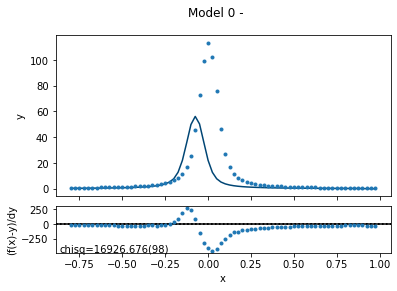

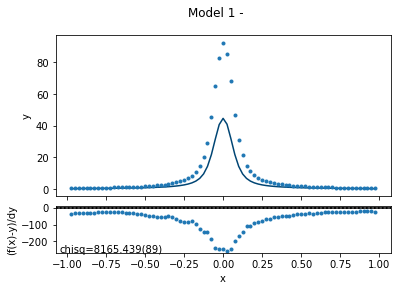

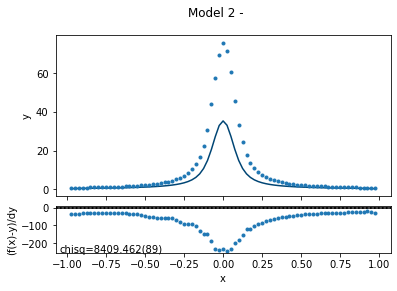

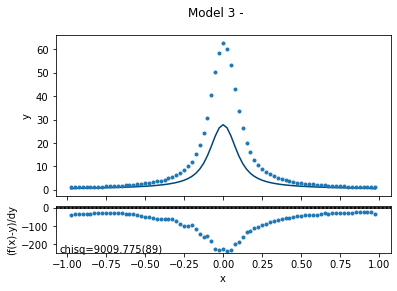

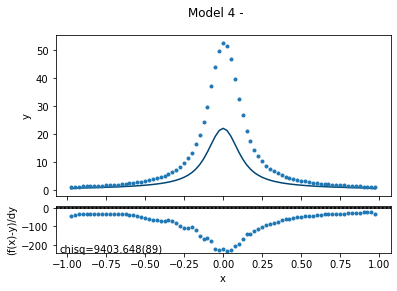

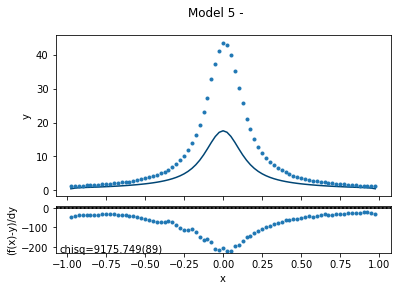

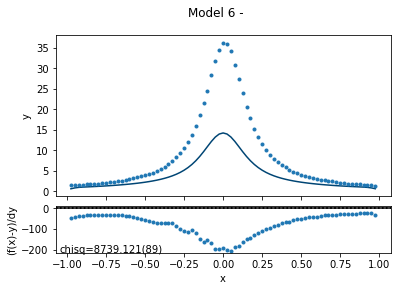

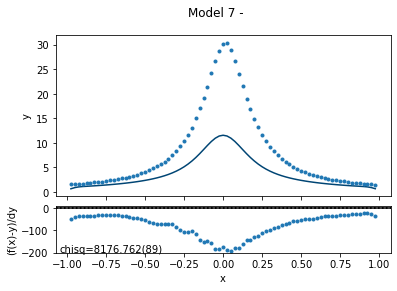

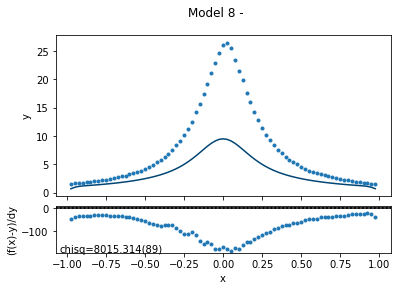

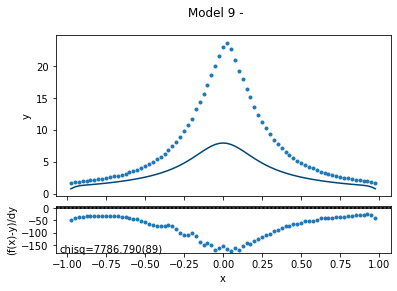

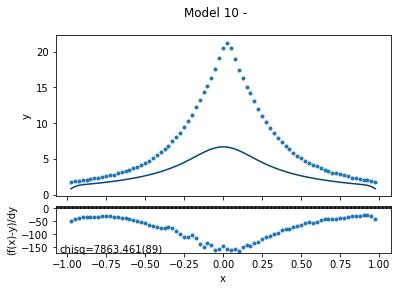

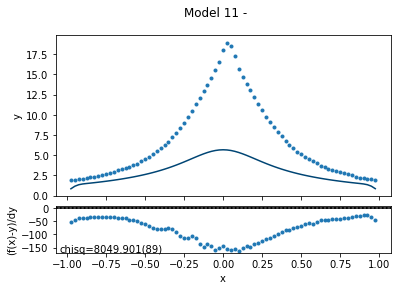

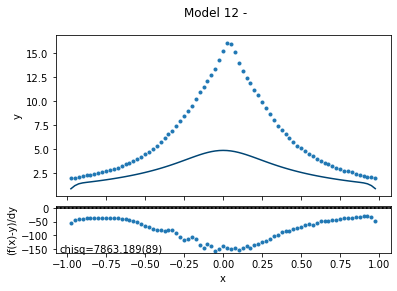

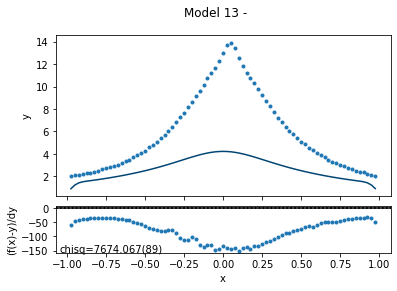

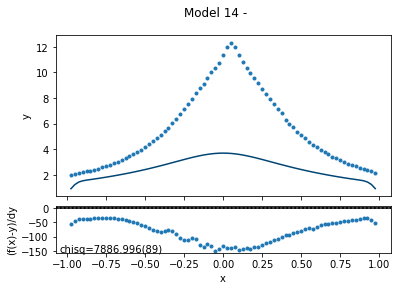

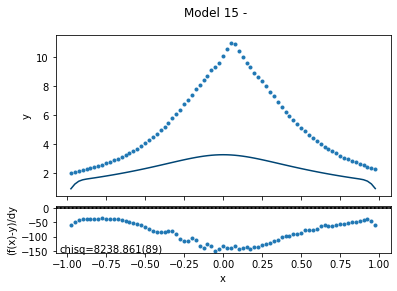

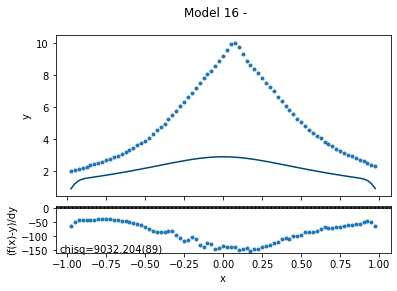

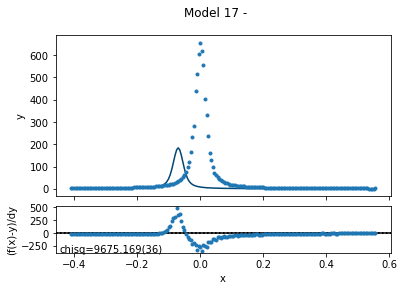

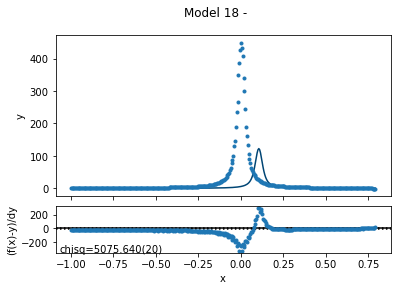

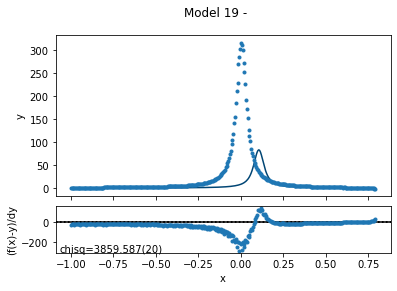

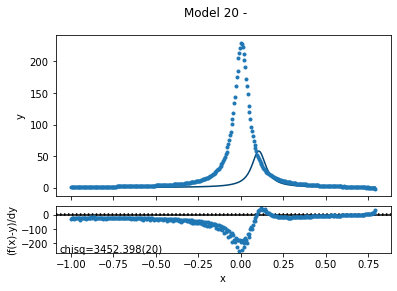

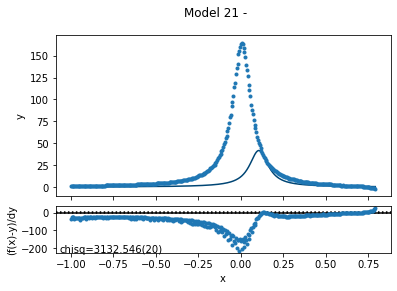

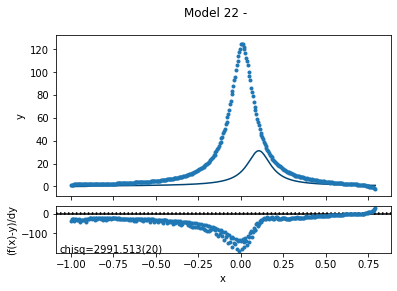

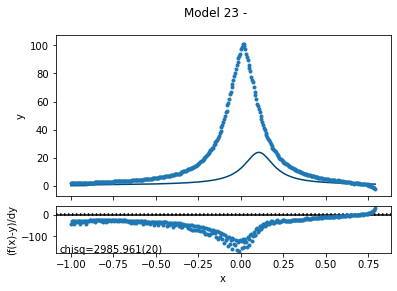

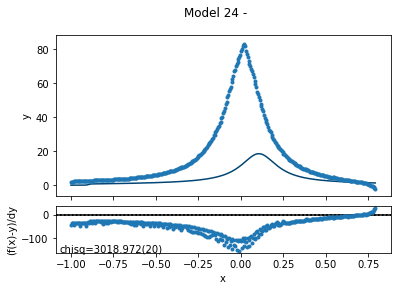

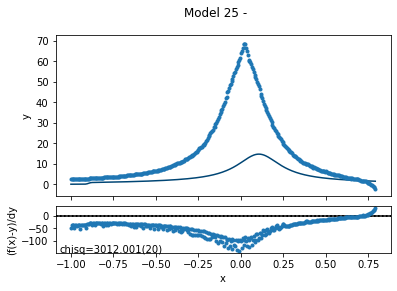

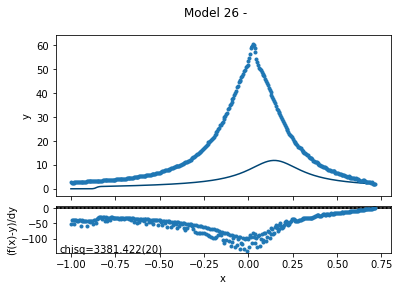

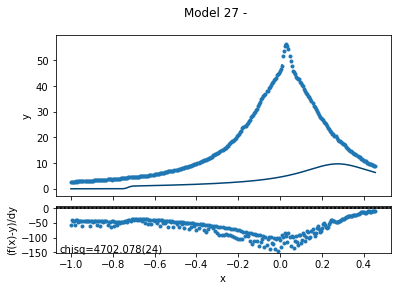

In [9]:
problem.plot()

In [10]:
problem.show()

-- Model 0 
.D = 0.13 in [0.05,0.25]
.DR = 0.3 in [0,1]
.center = 0 in [-0.1,0.1]
.q = 0.5
.radius = 1 in [0.9,1.1]
.resTime = 0.1 in [0,1]
.scale = 10 in [0,100]

[chisq=16926.676(98), nllf=609360]
-- Model 1 
.D = 0.13 in [0.05,0.25]
.DR = 0.3 in [0,1]
.center = 0 in [-0.1,0.1]
.q = 0.6
.radius = 1 in [0.9,1.1]
.resTime = 0.1 in [0,1]
.scale = 10 in [0,100]

[chisq=8165.439(89), nllf=322535]
-- Model 2 
.D = 0.13 in [0.05,0.25]
.DR = 0.3 in [0,1]
.center = 0 in [-0.1,0.1]
.q = 0.7
.radius = 1 in [0.9,1.1]
.resTime = 0.1 in [0,1]
.scale = 10 in [0,100]

[chisq=8409.462(89), nllf=332174]
-- Model 3 
.D = 0.13 in [0.05,0.25]
.DR = 0.3 in [0,1]
.center = 0 in [-0.1,0.1]
.q = 0.8
.radius = 1 in [0.9,1.1]
.resTime = 0.1 in [0,1]
.scale = 10 in [0,100]

[chisq=9009.775(89), nllf=355886]
-- Model 4 
.D = 0.13 in [0.05,0.25]
.DR = 0.3 in [0,1]
.center = 0 in [-0.1,0.1]
.q = 0.9
.radius = 1 in [0.9,1.1]
.resTime = 0.1 in [0,1]
.scale = 10 in [0,100]

[chisq=9403.648(89), nllf=371444]
-- Model 

## Running the fit

Run the fit using the *minimizer* defined above with a number of *steps* also specified above.

In [11]:
result = fit(problem, 
             method=options_dict[w_choice_minimizer.value], 
             steps=int(steps_fitting.value))

## Showing the results

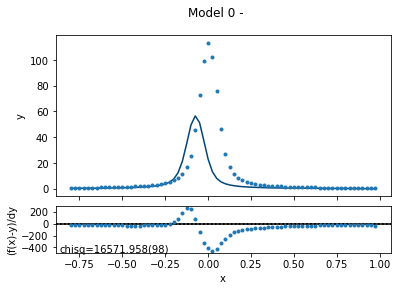

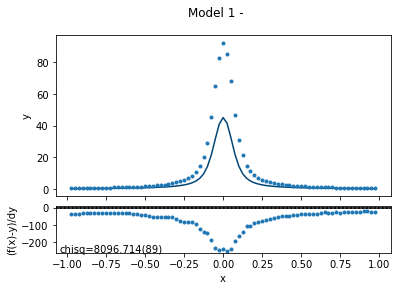

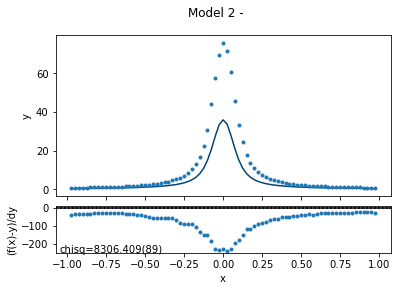

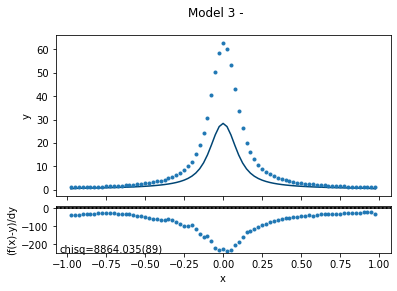

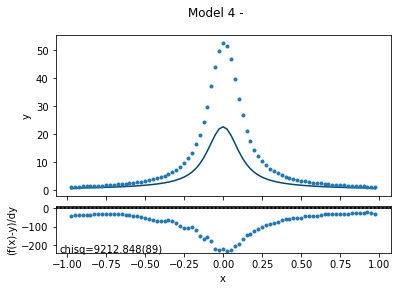

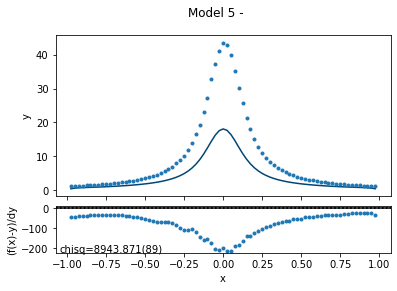

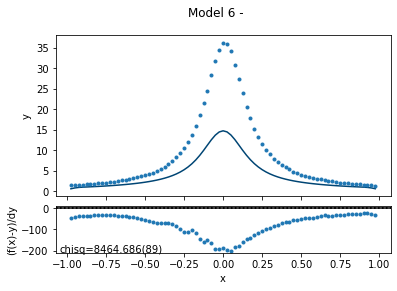

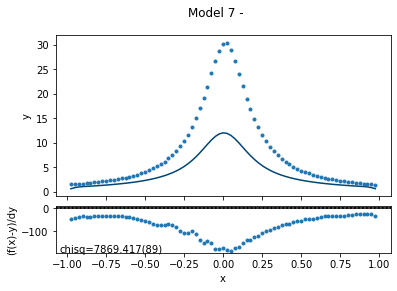

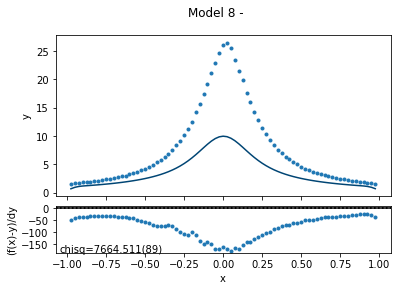

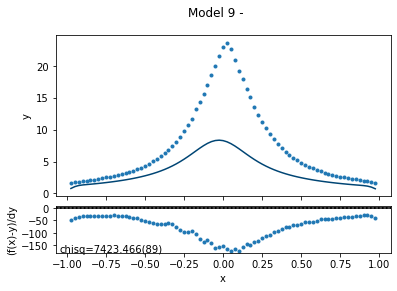

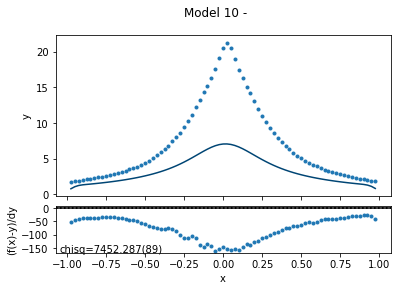

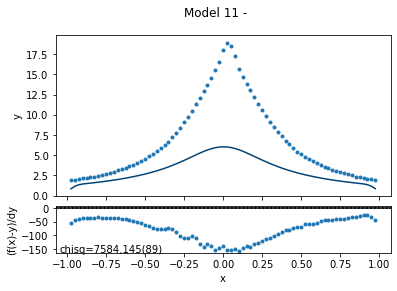

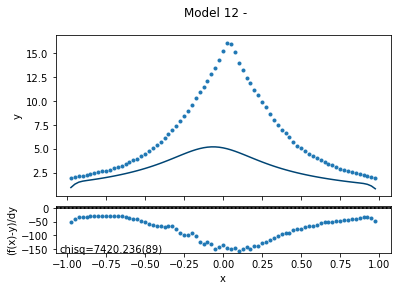

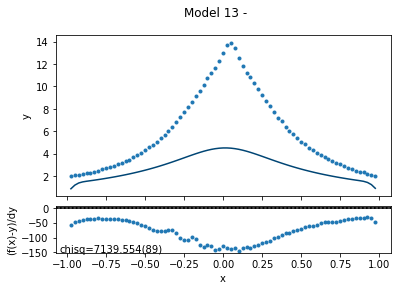

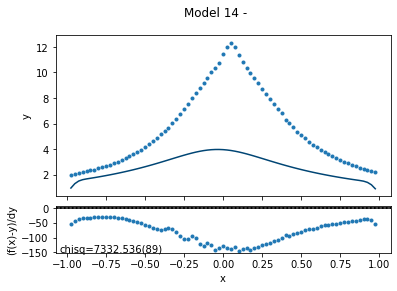

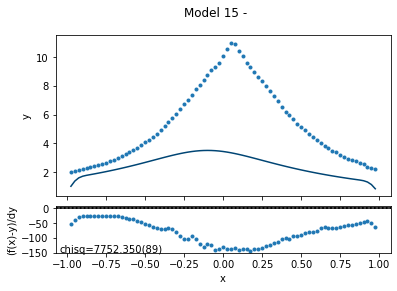

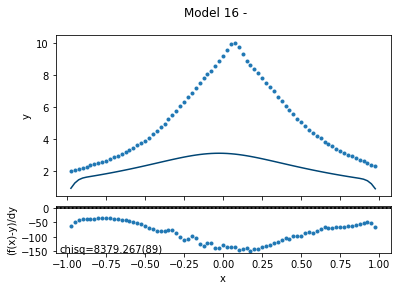

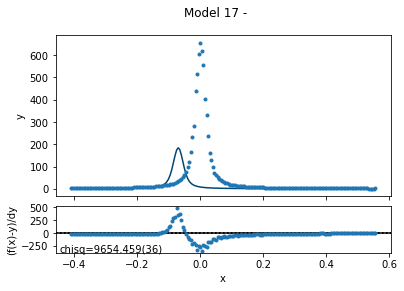

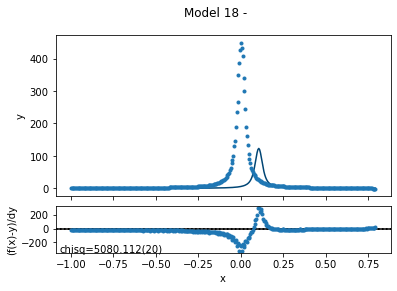

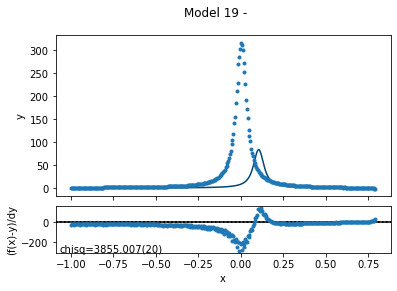

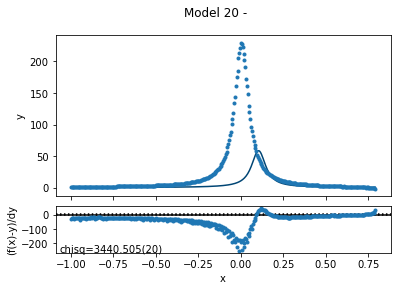

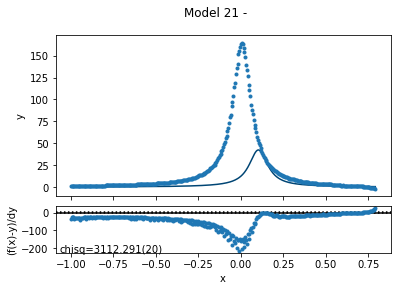

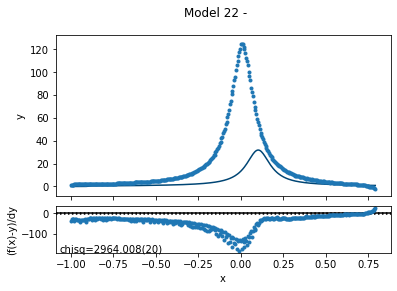

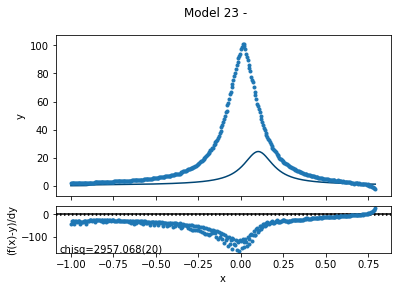

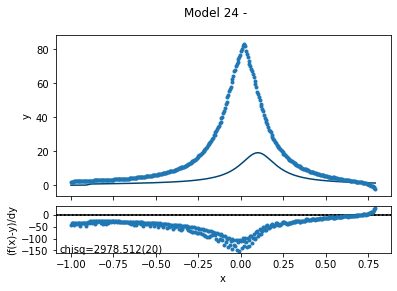

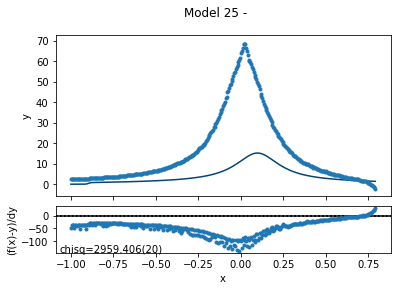

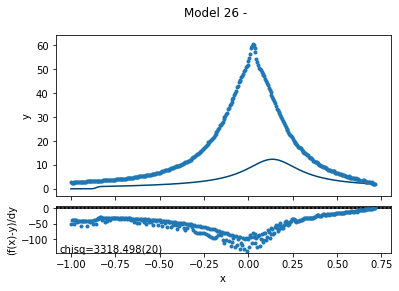

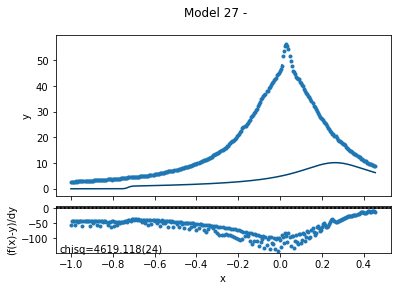

In [12]:
problem.plot()

In [13]:
# Display fitting results
problem.show()

-- Model 0 
.D = 0.130262 in [0.05,0.25]
.DR = 0.292307 in [0,1]
.center = 0.00167317 in [-0.1,0.1]
.q = 0.5
.radius = 0.943652 in [0.9,1.1]
.resTime = 0.1 in [0,1]
.scale = 10 in [0,100]

[chisq=16571.958(98), nllf=596590]
-- Model 1 
.D = 0.130262 in [0.05,0.25]
.DR = 0.292307 in [0,1]
.center = 0.00066314 in [-0.1,0.1]
.q = 0.6
.radius = 0.943652 in [0.9,1.1]
.resTime = 0.1 in [0,1]
.scale = 10 in [0,100]

[chisq=8096.714(89), nllf=319820]
-- Model 2 
.D = 0.130262 in [0.05,0.25]
.DR = 0.292307 in [0,1]
.center = 0.000579555 in [-0.1,0.1]
.q = 0.7
.radius = 0.943652 in [0.9,1.1]
.resTime = 0.1 in [0,1]
.scale = 10 in [0,100]

[chisq=8306.409(89), nllf=328103]
-- Model 3 
.D = 0.130262 in [0.05,0.25]
.DR = 0.292307 in [0,1]
.center = -0.000316045 in [-0.1,0.1]
.q = 0.8
.radius = 0.943652 in [0.9,1.1]
.resTime = 0.1 in [0,1]
.scale = 10 in [0,100]

[chisq=8864.035(89), nllf=350129]
-- Model 4 
.D = 0.130262 in [0.05,0.25]
.DR = 0.292307 in [0,1]
.center = -0.000814346 in [-0.1,0.1]
.q

In [14]:
# Print chi**2 and parameters' values after fit
print("final chisq", problem.chisq_str())
for k, v, dv in zip(problem.labels(), result.x, result.dx):
    if k in dict_physical_units.keys():
        print(k, ":", format_uncertainty(v, dv), dict_physical_units[k])
    else:
        print(k, ":", format_uncertainty(v, dv))

final chisq 5118.247(13)
D : 0.13026(16) Angstrom^2/ps
DR : 0.2923(26)
center : 0.001673(86) 1/ps
radius : 0.9437(21) Angstrom
resTime : 0.1000(77) ps
scale : 10.000(12) unit_of_signal/ps
center : 0.66(12)e-3 1/ps
scale : 10.000(14) unit_of_signal/ps
center : 0.58(16)e-3 1/ps
scale : 10.000(14) unit_of_signal/ps
center : -0.32(23)e-3 1/ps
scale : 10.000(14) unit_of_signal/ps
center : -0.81(24)e-3 1/ps
scale : 10.000(15) unit_of_signal/ps
center : 0.00122(31) 1/ps
scale : 10.000(15) unit_of_signal/ps
center : 0.36(35)e-3 1/ps
scale : 10.000(16) unit_of_signal/ps
center : 0.00440(45) 1/ps
scale : 10.000(16) unit_of_signal/ps
center : 0.00171(52) 1/ps
scale : 10.000(17) unit_of_signal/ps
center : -0.02673(64) 1/ps
scale : 10.000(18) unit_of_signal/ps
center : 0.01469(75) 1/ps
scale : 10.000(19) unit_of_signal/ps
center : 0.00226(92) 1/ps
scale : 10.000(19) unit_of_signal/ps
center : -0.0648(10) 1/ps
scale : 10.000(20) unit_of_signal/ps
center : 0.0131(12) 1/ps
scale : 10.000(21) unit_of_s